## Task 2: Evaluation of the ANN model and analysis of the results

In this section, I extended the neural network introduced in part 1 with additional code aimed at evaluating its performance comprehensively. To achieve this, I employed 5-fold cross-validation, a robust technique that ensures a thorough assessment of the model across various combinations of training and testing data.

The evaluation process yielded crucial insights, including a detailed confusion matrix encapsulating the model's predictions across all 5 folds. From these results, I derived essential statistics such as the F1 score, recall, and accuracy, offering a comprehensive view of the model's efficacy.

Furthermore, I visualized the confusion matrix alongside key performance metrics, enabling a clear understanding of the model's strengths and areas for improvement. Additionally, I updated error rate and accuracy rate graphs using the mean values obtained from each fold, providing a more stable representation of the model's performance trends.

Moreover, I generated an ROC graph to determine the optimal threshold for predictions, enhancing the model's predictive capabilities and refining its decision-making process. This comprehensive evaluation framework not only validates the model's performance but also guides future optimizations for enhanced accuracy and reliability.

### Data Loading and Setup
- Loads the Breast Cancer Wisconsin dataset.
- Splits the dataset into features (x) and target labels (y).


In [4]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
import pandas as pd

# Load the breast cancer Wisconsin dataset
data = load_breast_cancer()
x = data.data
y = data.target

### Neural Network Configuration
- Defines parameters for the neural network such as input size, hidden layer size, output size, learning rate, number of epochs, batch size, and cross-validation folds.

In [5]:
# Define the neural network architecture
np.random.seed(0)
input_size = x.shape[1]
hidden_size = 5
output_size = 1
learning_rate = 0.01
epochs = 500
batch_size = 128
k_cv = 5

### Cross-validation Setup
- Sets up K-Fold cross-validation with the specified number of folds (k_cv).

In [6]:
# Define the cross validation params
kfold = KFold(n_splits=k_cv, shuffle=True, random_state=42)

### Results Tracking
- Initializes a dictionary (scoring) to store various performance metrics during training and testing.

In [7]:
# Dictionary to store results
scoring = {
    'accuracy': {
        'training': np.zeros((5, epochs)), 
        'testing': np.zeros((5, epochs))
    },
    'error': {
        'training': np.zeros((5, epochs)),
        'testing': np.zeros((5, epochs))
    },
    'precision': {
        'training': np.zeros(1),
        'testing': np.zeros(1)
    },
    'recall': {
        'training': np.zeros(1),
        'testing': np.zeros(1)
    },
    'f1 score': {
        'training': np.zeros(1),
        'testing': np.zeros(1)
    },
    'cm_accuracy': {
        'training': np.zeros(1),
        'testing': np.zeros(1)
    },
    'cm': {
        'training': np.zeros((2, 2)),
        'testing': np.zeros((2, 2))
    }
}

### Sigmoid and loss Functions and their Derivative's
- Defines the sigmoid function and its derivative.
- Sigmoid function maps the input to a value between 0 and 1.
- Sigmoid derivative calculates the gradient of the sigmoid function.
- Defines the cross-entropy loss function and its derivative.
- Cross-entropy is used as the loss function for binary classification tasks.

In [8]:
# Define sigmoid and its derivative
def sigmoid(v):
    return 1 / (1 + np.exp(-np.clip(v, -500, 500)))

def sigmoid_derivative(v):
    sig = sigmoid(v)
    sig_prime = sig * (1 - sig)
    return sig_prime

# Loss function and its derivative
def crossEntropy(o, y):
    return (-y * np.log(o) - (1 - y) * np.log(1 - o))

def crossEntropyDeriv(o, y):
    return -(y / o - (1 - y) / (1 - o))


### Mini-Batch Creation Function
- Defines a function to create mini-batches from the dataset.
- Splits the data into batches of specified size.

In [9]:
# Mini-batch creation function
def create_mini_batches(data, batch_size):
    num_samples = data.shape[0]
    num_batches = num_samples // batch_size

    mini_batches = [data[i * batch_size:(i + 1) * batch_size] for i in range(num_batches)]

    if num_samples % batch_size != 0:
        mini_batches.append(data[num_batches * batch_size:])

    return mini_batches

 ### Initialization of Weights and Biases

In [10]:
# Initialize weights and biases
def initialize_params():
    w1 = np.random.uniform(-1, 1, (input_size, hidden_size))
    b1 = np.zeros((1, hidden_size))
    w2 = np.random.uniform(-1, 1, (hidden_size, output_size))
    b2 = np.zeros((1, output_size))
    return w1, b1, w2, b2

### Model Training
- Defines a function to train the neural network model.
- Initializes parameters and conducts forward and backward passes for each epoch.
- Updates weights and biases using gradient descent.
- Computes and stores performance metrics for training and testing.

In [11]:
# Train the model
def train_model(X_train, y_train, X_test, y_test, epochs):
    w1, b1, w2, b2 = initialize_params()

    training_data = np.hstack((X_train, y_train.reshape(-1, 1)))

    for epoch in range(epochs):
        np.random.shuffle(training_data)

        batch_train_errors = []
        batch_train_accuracy = []

        for batch in create_mini_batches(training_data, batch_size):
            in1 = batch[:, :-1] @ w1 + b1
            o1 = sigmoid(in1)
            in2 = o1 @ w2 + b2
            o2 = sigmoid(in2)

            y_batch = batch[:, -1:]
            batch_train_errors.append(crossEntropy(o2, y_batch).mean())

            pred_train = np.where(o2 > 0.5, 1, 0)
            batch_train_accuracy.append(metrics.accuracy_score(y_batch, pred_train))

            dE_dO2 = crossEntropyDeriv(o2, y_batch)
            dO2_dIn2 = sigmoid_derivative(in2)
            dIn2_dW2 = o1
            dE_dW2 = (1 / batch.shape[0]) * dIn2_dW2.T @ (dE_dO2 * dO2_dIn2)
            dE_dB2 = (1 / batch.shape[0]) * np.ones([1, len(batch)]) @ (dE_dO2 * dO2_dIn2)

            dIn2_dO1 = w2
            dO1_dIn1 = sigmoid_derivative(in1)
            dIn1_dW1 = batch[:, :-1]
            dE_dW1 = (1 / batch.shape[0]) * dIn1_dW1.T @ ((dE_dO2 * dO2_dIn2 @ dIn2_dO1.T) * dO1_dIn1)
            dE_dB1 = (1 / batch.shape[0]) * np.ones([len(batch)]) @ ((dE_dO2 * dO2_dIn2 @ dIn2_dO1.T) * dO1_dIn1)

            b2 -= learning_rate * dE_dB2
            w2 -= learning_rate * dE_dW2
            b1 -= learning_rate * dE_dB1
            w1 -= learning_rate * dE_dW1

        scoring['accuracy']['training'][k, epoch] = np.array(batch_train_accuracy).mean()
        pred_test_accuracy = np.where(sigmoid(sigmoid(X_test @ w1 + b1) @ w2 + b2) > 0.5, 1, 0)
        scoring['accuracy']['testing'][k, epoch] = (metrics.accuracy_score(y_test, pred_test_accuracy))
        scoring['error']['training'][k, epoch] = (np.array(batch_train_errors).mean())
        pred_test_error = np.array(sigmoid(sigmoid(X_test @ w1 + b1) @ w2 + b2)).flatten()
        scoring['error']['testing'][k, epoch] = crossEntropy(pred_test_error, y_test).mean()

    return w1, b1, w2, b2

### Update Scores Based on Confusion Matrix
- Defines a function to update performance scores based on the confusion matrix.
- Calculates precision, recall, F1 score, and accuracy.
- Updates the scoring dictionary with the computed metrics.

In [12]:
# Update scores based on confusion matrix
def update_scores(scoring, y_true, y_pred, dataset_type):
    conf_matrix = confusion_matrix(y_true, y_pred)
    TP, FP, FN, TN = conf_matrix[1, 1], conf_matrix[0, 1], conf_matrix[1, 0], conf_matrix[0, 0]

    scoring['cm'][dataset_type][1, 1] += TP
    scoring['cm'][dataset_type][0, 1] += FP
    scoring['cm'][dataset_type][1, 0] += FN
    scoring['cm'][dataset_type][0, 0] += TN

    precision = TP / (TP + FP)
    scoring['precision'][dataset_type][0] += precision

    recall = TP / (TP + FN)
    scoring['recall'][dataset_type][0] += recall

    if precision + recall > 0:
        f1_score = 2 * (precision * recall) / (precision + recall)
    else:
        f1_score = 0
    scoring['f1 score'][dataset_type][0] += f1_score

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    scoring['cm_accuracy'][dataset_type][0] += accuracy

### Cross-Validated Training
- Conducts cross-validated training using K-Fold cross-validation.
- Splits the data into training and testing sets for each fold.
- Trains the model and updates performance scores for both training and testing.

In [13]:
k = 0

# Cross-validated training
for train_index, test_index in kfold.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    w1, b1, w2, b2 = train_model(X_train, y_train, X_test, y_test, epochs)
    
    final_test_predictions = np.where(sigmoid(sigmoid(X_test @ w1 + b1) @ w2 + b2) > 0.5, 1, 0)
    final_training_predictions = np.where(sigmoid(sigmoid(X_train @ w1 + b1) @ w2 + b2) > 0.5, 1, 0)

    update_scores(scoring, y_test, final_test_predictions, 'testing')
    update_scores(scoring, y_train, final_training_predictions, 'training')

    k += 1

### Visualizing Model Performance
- Visualizes the model performance using various plots and metrics.
- Plots the cross-validated error and accuracy over epochs.
- Displays confusion matrices for both training and testing data folds.
- Calculates and plots the Receiver Operating Characteristic (ROC) curve.

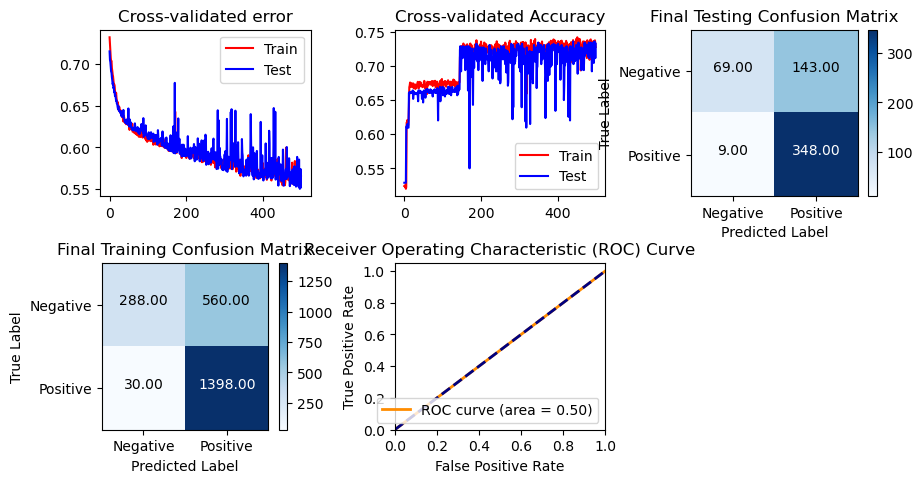

In [14]:
# Visualise model performance using training and testing confusion matrix's

# get the aggregate of each column to get the mean of the cross validated accuracies for better analysis
scoring['accuracy']['training'] = np.mean(scoring['accuracy']['training'], axis=0)
scoring['accuracy']['testing'] = np.mean(scoring['accuracy']['testing'] , axis=0)
scoring['error']['training'] = np.mean(scoring['error']['training'], axis=0)
scoring['error']['testing'] = np.mean(scoring['error']['testing'], axis=0)

# plot mean cross validated accuracy and error for more accurate evaluation

epochs_range = np.arange(epochs)
plt.figure(figsize=(10, 5))

plt.subplot(2, 3, 1)
plt.plot(epochs_range, scoring['error']['training'], label="Train", color='red')
plt.plot(epochs_range, scoring['error']['testing'], label="Test", color='blue')
plt.legend(loc='best')
plt.title('Cross-validated error')

plt.subplot(2, 3, 2)
plt.plot(epochs_range, scoring['accuracy']['training'], label="Train", color='red')
plt.plot(epochs_range, scoring['accuracy']['testing'], label="Test", color='blue')
plt.legend(loc='best')
plt.title('Cross-validated Accuracy')


# plotting confusion matrice's for training and test data folds
plt.subplot(2,3,3)
testing_cm = scoring['cm']['testing']
plt.imshow(testing_cm, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
plt.title('Final Testing Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add annotations
for i in range(testing_cm.shape[0]):
    for j in range(testing_cm.shape[1]):
        plt.text(j, i, format(testing_cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if testing_cm[i, j] > testing_cm.max() / 2. else "black")
        
# Add tick marks
classes = ['Negative', 'Positive']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.subplot(2,3, 4)
testing_cm = scoring['cm']['training']
plt.imshow(testing_cm, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
plt.title('Final Training Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add annotations
for i in range(testing_cm.shape[0]):
    for j in range(testing_cm.shape[1]):
        plt.text(j, i, format(testing_cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if testing_cm[i, j] > testing_cm.max() / 2. else "black")

# Add tick marks
classes = ['Negative', 'Positive']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)


# Perform ROC curver graph calculations on entire dataset
plt.subplot(2,3, 5)
final_test_predictions = sigmoid(sigmoid(np.concatenate((X_test, X_train)) @ w1 + b1) @ w2 + b2)
# Calculate ROC curve for the testing dataset
fpr, tpr, thresholds = roc_curve(np.concatenate((y_test, y_train)), final_test_predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Display the plot
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()


### Print baseline model statistics
- The code prints baseline model statistics.
- It organizes training and testing error and accuracy statistics into dictionaries.
- Using these dictionaries, DataFrames for training and testing statistics are created.
- The code then prints out these DataFrames.
- Additionally, precision, recall, F1 score, and confusion matrix accuracy statistics are defined and averaged for both training and testing datasets.
DataFrames for these statistics are created and concatenated into one DataFrame.
- Finally, the code prints the DataFrame containing the confusion matrix statistics for both datasets.



In [15]:
# Print baseline model statistics
# Define the training and testing error and accuracy stats
training_stats = {
    'Metric': ['First Error', 'Final Error', 'First Accuracy', 'Final Accuracy'],
    'Value': [scoring['error']['training'][0], scoring['error']['training'][-1], scoring['accuracy']['training'][0], scoring['accuracy']['training'][-1]]
}

testing_stats = {
    'Metric': ['First Error', 'Final Error', 'First Accuracy', 'Final Accuracy'],
    'Value': [scoring['error']['testing'][0], scoring['error']['testing'][-1], scoring['accuracy']['testing'][0], scoring['accuracy']['testing'][-1]]
}

# Create DataFrames
training_df = pd.DataFrame(training_stats)
testing_df = pd.DataFrame(testing_stats)

# Print DataFrames
print ("Training Stats:")
print (training_df)
print ("\nTesting Stats:")
print (testing_df)
print ()

# Define statistics
training_stats = {
    'Precision': scoring['precision']['training'][0] / 5,
    'Recall': scoring['recall']['training'][0] / 5,
    'F1 Score': scoring['f1 score']['training'][0] / 5,
    'Confusion Matrix Accuracy': scoring['cm_accuracy']['training'][0] / 5
}

testing_stats = {
    'Precision': scoring['precision']['testing'][0] / 5,
    'Recall': scoring['recall']['testing'][0] / 5,
    'F1 Score': scoring['f1 score']['testing'][0] / 5,
    'Confusion Matrix Accuracy': scoring['cm_accuracy']['testing'][0] / 5
}

# Create DataFrame
df_training = pd.DataFrame(training_stats, index=['Training'])
df_testing = pd.DataFrame(testing_stats, index=['Testing'])

# Concatenate DataFrames
df_statistics = pd.concat([df_training, df_testing])

# Print DataFrame
print("Confusion Matrix Statistics:")
print(df_statistics)


Training Stats:
           Metric     Value
0     First Error  0.731742
1     Final Error  0.565073
2  First Accuracy  0.524296
3  Final Accuracy  0.727821

Testing Stats:
           Metric     Value
0     First Error  0.714878
1     Final Error  0.552277
2  First Accuracy  0.529110
3  Final Accuracy  0.732619

Confusion Matrix Statistics:
          Precision    Recall  F1 Score  Confusion Matrix Accuracy
Training   0.738918  0.978796   0.83413                   0.740819
Testing    0.738119  0.975306   0.82869                   0.732619
